# Rent the Runway Code

### Imports

In [2]:
import pandas as pd
import numpy as np
import json
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

In [3]:
# Read in the json file
df = pd.read_json('data/renttherunway_final_data.json', lines=True)

def unpack(x):
    rv = []
    for v in x:
        if isinstance(v, dict):
            rv.append([*v.values()][0])
        else:
            rv.append(v)
    return rv

df = df.apply(unpack)
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


## EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fit             192544 non-null  object 
 1   user_id         192544 non-null  int64  
 2   bust size       174133 non-null  object 
 3   item_id         192544 non-null  int64  
 4   weight          162562 non-null  object 
 5   rating          192462 non-null  float64
 6   rented for      192534 non-null  object 
 7   review_text     192544 non-null  object 
 8   body type       177907 non-null  object 
 9   review_summary  192544 non-null  object 
 10  category        192544 non-null  object 
 11  height          191867 non-null  object 
 12  size            192544 non-null  int64  
 13  age             191584 non-null  float64
 14  review_date     192544 non-null  object 
dtypes: float64(2), int64(3), object(10)
memory usage: 22.0+ MB


In [5]:
df.describe()

,user_id,item_id,rating,size,age
count,192544.000000,1.925440e+05,192462.000000,192544.000000,191584.000000
mean,499494.100149,1.045684e+06,9.092371,12.245175,33.871017
std,289059.719328,8.053148e+05,1.430044,8.494877,8.058083
min,9.000000,1.233730e+05,2.000000,0.000000,0.000000
25%,250654.250000,1.950760e+05,8.000000,8.000000,29.000000
50%,499419.000000,9.483960e+05,10.000000,12.000000,32.000000
75%,750974.000000,1.678888e+06,10.000000,16.000000,37.000000
max,999997.000000,2.966087e+06,10.000000,58.000000,117.000000


### Time Frame: 
**November 3, 2010 to January 8, 2018**

In [6]:
# create new column where string date column is datetime
df['review date'] = pd.to_datetime(df['review_date'], format='%B %d, %Y')
df['review date']

0        2016-04-20
1        2013-06-18
2        2015-12-14
3        2014-02-12
4        2016-09-26
            ...    
192539   2016-05-18
192540   2016-09-30
192541   2016-03-04
192542   2015-11-25
192543   2017-08-29
Name: review date, Length: 192544, dtype: datetime64[ns]

In [7]:
#drop original string date column
df.drop(['review_date'], axis=1, inplace=True)

In [8]:
from_date = df['review date'].min()
from_date

Timestamp('2010-11-03 00:00:00')

In [9]:
to_date = df['review date'].max()
to_date

Timestamp('2018-01-08 00:00:00')

### Ratings Overall

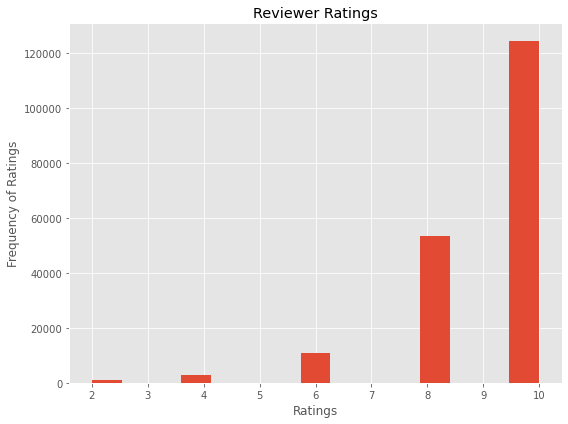

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
plt.style.use('ggplot')
plt.hist(x=df['rating'], bins=15)
ax.set_title('Reviewer Ratings')
ax.set_xlabel('Ratings')
ax.set_ylabel('Frequency of Ratings')
plt.tight_layout()

In [12]:
#counts per rating
df['rating'].value_counts(dropna=False)
# [82, 1046, 2791, 10697, 53391, 124537]

10.0    124537
8.0      53391
6.0      10697
4.0       2791
2.0       1046
NaN         82
Name: rating, dtype: int64

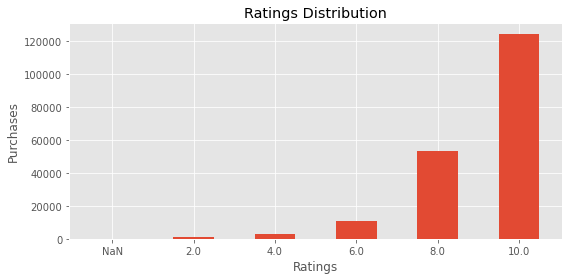

In [13]:
#ratings distribution without odd number ratings -- more representative of a 5-point scale with NaN
fig, ax = plt.subplots(figsize=(8,4))
plt.style.use('ggplot')
plt.bar(['NaN', '2.0', '4.0', '6.0', '8.0', '10.0'], [82, 1046, 2791, 10697, 53391, 124537], width=0.5)
ax.set_title('Ratings Distribution')
ax.set_xlabel('Ratings')
ax.set_ylabel('Purchases')
plt.tight_layout()

### Average Rating by Fit

In [14]:
fit_categories = df.groupby(['fit'])
names = []
avg_ratings = []
for category_name,category_df in fit_categories:
    avg_ratings.append(category_df['rating'].mean())
    names.append(category_name)

In [15]:
names
avg_ratings = np.round(avg_ratings, 2)
avg_ratings

array([9.31, 8.55, 8.42])

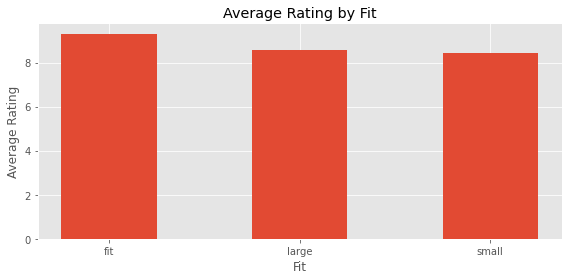

In [16]:
fig, ax = plt.subplots(figsize=(8,4))
plt.style.use('ggplot')
plt.bar(x=names, height=avg_ratings, width=0.5)
ax.set_title('Average Rating by Fit')
ax.set_xlabel('Fit')
ax.set_ylabel('Average Rating')
plt.tight_layout()

### Size

In [17]:
# size count
size_categories = df.groupby(['size'])
sizes = []
amounts_by_size = []
for category_name,category_df in size_categories:
    sizes.append(category_name)
    amounts_by_size.append(category_df['size'].count())

In [18]:
# sizes
# amounts_by_size
df['size'].mean()

12.245175128801728

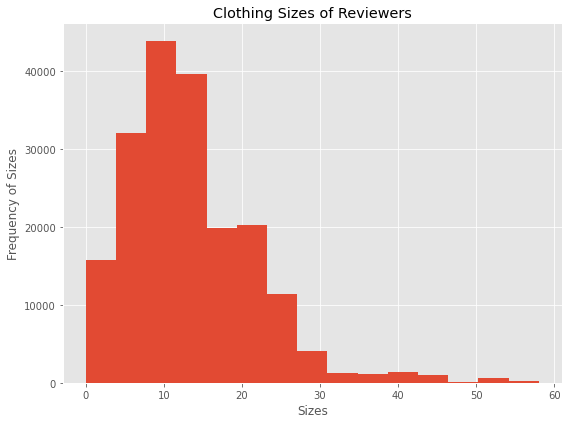

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
plt.style.use('ggplot')
plt.hist(x=df['size'], bins=15)
ax.set_title('Clothing Sizes of Reviewers')
ax.set_xlabel('Sizes')
ax.set_ylabel('Frequency of Sizes')
plt.tight_layout()
#shoppers tend to hang around sizes 8 - 12. RTR generally has clothing up to size 22 
#so values beyond that could be user error or different clothing attributes.

### Clothing Types
**Top Categories**

In [20]:
top_10_categories = df['category'].value_counts().head(10)
top_10_categories

dress       92884
gown        44381
sheath      19316
shift        5365
jumpsuit     5184
top          4931
maxi         3443
romper       3070
jacket       2404
mini         1751
Name: category, dtype: int64

In [21]:
category_count = []
for categories in top_10_categories:
    category_count.append(categories)

category_count

[92884, 44381, 19316, 5365, 5184, 4931, 3443, 3070, 2404, 1751]

**Occasions**

In [22]:
top_occasions = df['rented for'].value_counts()
top_occasions

wedding            57784
formal affair      40408
party              35626
everyday           16822
other              15388
work               15042
date                7388
vacation            4075
party: cocktail        1
Name: rented for, dtype: int64

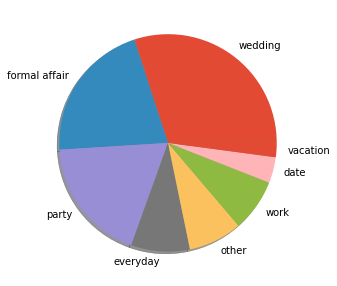

In [23]:
bought_occasion = np.array([57784, 40408, 35626, 16822, 15388, 15042, 7388, 4075])
reason = ['wedding', 'formal affair', 'party', 'everyday', 'other', 'work', 'date', 'vacation']
fig, ax = plt.subplots(figsize=(6, 5))
plt.pie(bought_occasion, labels = reason, shadow = True);

### Body Type

In [24]:
bt_categories = df.groupby(['body type'])
body_types = []
bt_avg_ratings = []
for category_name,category_df in bt_categories:
    bt_avg_ratings.append(category_df['rating'].mean())
    body_types.append(category_name)

In [25]:
body_types
bt_avg_ratings = np.round(bt_avg_ratings, 2)
bt_avg_ratings

array([8.93, 9.12, 9.02, 9.08, 9.04, 9.08, 9.16])

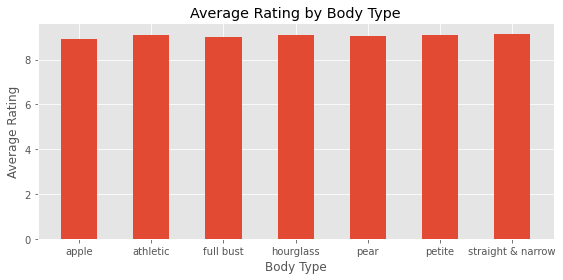

In [26]:
fig, ax = plt.subplots(figsize=(8,4))
plt.style.use('ggplot')
plt.bar(x=body_types, height=bt_avg_ratings, width=0.5)
ax.set_title('Average Rating by Body Type')
ax.set_xlabel('Body Type')
ax.set_ylabel('Average Rating')
plt.tight_layout()

### Cup Sizes

In [27]:
bra_sizes = df['bust size'].value_counts().head(10)
bra_sizes
# too many categories of bust sizes

34b    27285
34c    23139
34d    18029
36c    13516
32d    11196
36d    11122
32b    10911
32c     9943
36b     9676
34a     7891
Name: bust size, dtype: int64

In [28]:
# create new column with cup sizes only
df['cup_size'] = df['bust size'].str.slice(start=2)
df['cup_size'].head(10)

0      d
1      b
2    NaN
3      c
4      b
5      b
6      c
7     d+
8      d
9      b
Name: cup_size, dtype: object

In [29]:
# cup sizes per reviewer
cup_categories = df.groupby(['cup_size'])
cup_types = []
cup_count = []
for category_name,category_df in cup_categories:
    cup_count.append(category_df['cup_size'].count())
    cup_types.append(category_name)
cup_count

[15286, 710, 49110, 49634, 45008, 3956, 6703, 2602, 458, 440, 156, 40, 30]

In [30]:
cup_types

['a', 'aa', 'b', 'c', 'd', 'd+', 'dd', 'ddd/e', 'f', 'g', 'h', 'i', 'j']

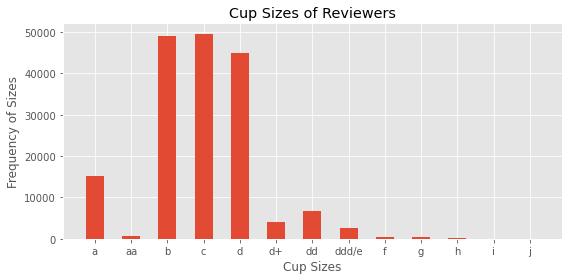

In [31]:
fig, ax = plt.subplots(figsize=(8,4))
plt.style.use('ggplot')
plt.bar(x=cup_types, height=cup_count, width=0.5)
ax.set_title('Cup Sizes of Reviewers')
ax.set_xlabel('Cup Sizes')
ax.set_ylabel('Frequency of Sizes')
plt.tight_layout()

In [32]:
#group by cup sizes now and compare with ratings
cup_categories = df.groupby(['cup_size'])
cup_types = []
cup_avg_ratings = []
for category_name,category_df in cup_categories:
    cup_avg_ratings.append(category_df['rating'].mean())
    cup_types.append(category_name)

In [33]:
cup_types
cup_avg_ratings = np.round(cup_avg_ratings, 2)
cup_avg_ratings

array([9.1 , 9.09, 9.12, 9.1 , 9.05, 8.96, 9.07, 9.14, 9.  , 8.81, 8.91,
       9.2 , 8.4 ])

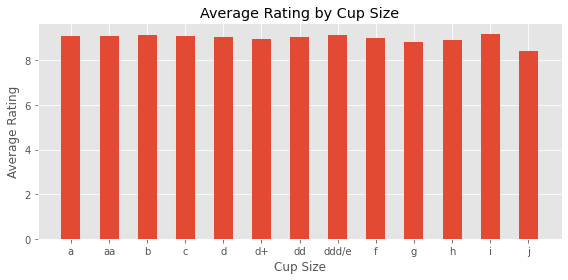

In [34]:
fig, ax = plt.subplots(figsize=(8,4))
plt.style.use('ggplot')
plt.bar(x=cup_types, height=cup_avg_ratings, width=0.5)
ax.set_title('Average Rating by Cup Size')
ax.set_xlabel('Cup Size')
ax.set_ylabel('Average Rating')
plt.tight_layout()

### Age

In [35]:
age_range = df['age'].value_counts().head(10)
age_range

31.0    14522
30.0    14145
29.0    13589
32.0    13508
28.0    11965
33.0    11882
34.0    10143
35.0     9036
27.0     8960
36.0     7710
Name: age, dtype: int64

In [36]:
#bin the ages for easier viewing of ages on x-axis
df['bin'] = pd.cut(df['age'], [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120], labels=['0-10', '10-20','20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100','100-120'])

In [37]:
df['bin'].value_counts().sort_index()

0-10          40
10-20       2082
20-30      70287
30-40      87805
40-50      22482
50-60       7349
60-70       1367
70-80         54
80-90          7
90-100        22
100-120       65
Name: bin, dtype: int64

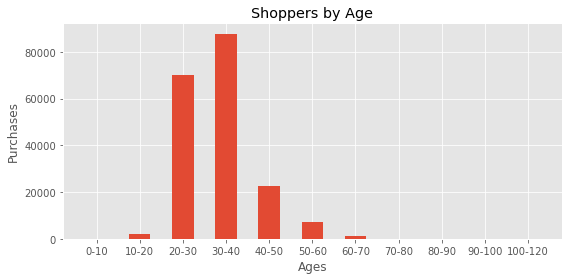

In [38]:
fig, ax = plt.subplots(figsize=(8,4))
plt.style.use('ggplot')
plt.bar(['0-10', '10-20','20-30', '30-40', '40-50', '50-60', '60-70', '70-80', 
         '80-90', '90-100','100-120'], df['bin'].value_counts().sort_index(), width=0.5)
ax.set_title('Shoppers by Age')
ax.set_xlabel('Ages')
ax.set_ylabel('Purchases')
plt.tight_layout()

### Common Words in Reviews 

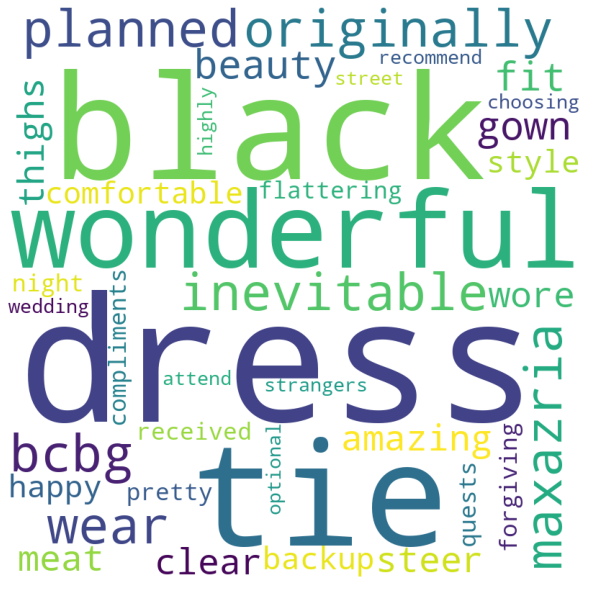

In [39]:
#create a wordcloud which excludes stopwords
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for val in df['review_text']: 
# typecaste each val to string 
   val = str(val) 
   # split the value 
   tokens = val.split() 

# Converts each token into lowercase 
for i in range(len(tokens)): 
    tokens[i] = tokens[i].lower() 

for words in tokens: 
    comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

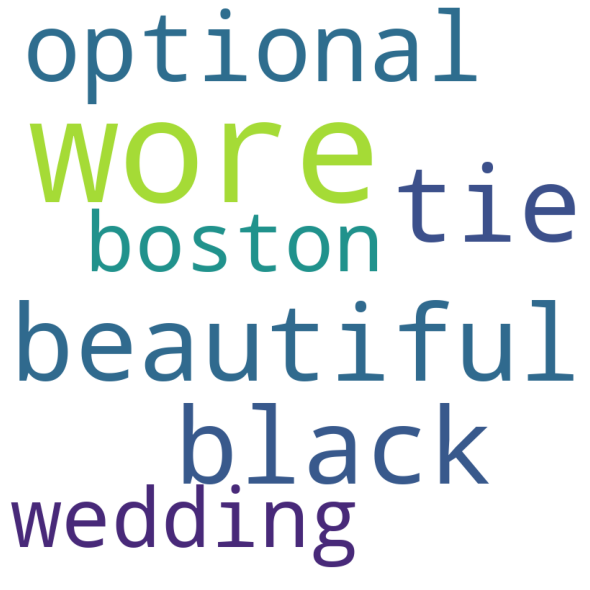

In [40]:
comment_words = ' '
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for val in df['review_summary']: 
# typecaste each val to string 
   val = str(val) 
   # split the value 
   tokens = val.split() 

# Converts each token into lowercase 
for i in range(len(tokens)): 
    tokens[i] = tokens[i].lower() 

for words in tokens: 
    comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

### Height

In [41]:
# count of women for each height
heights = df['height'].value_counts(dropna=False)
heights

5' 4"     28012
5' 6"     25680
5' 5"     24318
5' 7"     24020
5' 3"     20736
5' 2"     16762
5' 8"     16369
5' 9"     11371
5' 1"      7145
5' 10"     7041
5' 0"      4015
5' 11"     3114
6' 0"      1406
4' 11"     1014
NaN         677
6' 1"       364
4' 10"      212
6' 2"       124
4' 9"        60
6' 3"        31
4' 6"        20
6' 4"        18
4' 8"        17
4' 7"        16
6' 6"         2
Name: height, dtype: int64

In [42]:
height_categories = df.groupby(['height'])
heights = []
height_count = []
for category_name,category_df in height_categories:
    height_count.append(category_df['height'].count())
    heights.append(category_name)
heights
# height_count

['4\' 10"',
 '4\' 11"',
 '4\' 6"',
 '4\' 7"',
 '4\' 8"',
 '4\' 9"',
 '5\' 0"',
 '5\' 1"',
 '5\' 10"',
 '5\' 11"',
 '5\' 2"',
 '5\' 3"',
 '5\' 4"',
 '5\' 5"',
 '5\' 6"',
 '5\' 7"',
 '5\' 8"',
 '5\' 9"',
 '6\' 0"',
 '6\' 1"',
 '6\' 2"',
 '6\' 3"',
 '6\' 4"',
 '6\' 6"']

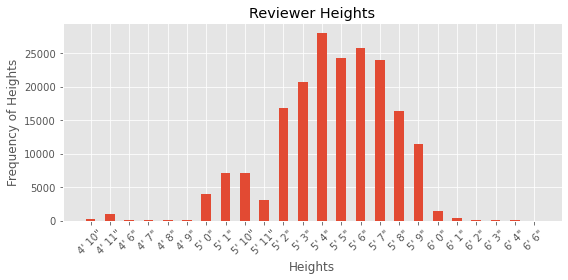

In [43]:
fig, ax = plt.subplots(figsize=(8,4))
plt.style.use('ggplot')
plt.bar(x=heights, height=height_count, width=0.5)
plt.xticks(rotation = 45)
ax.set_title('Reviewer Heights')
ax.set_xlabel('Heights')
ax.set_ylabel('Frequency of Heights')
plt.tight_layout()

## Hypothesis Testing
> H0: There is no difference in the average ratings of Loyal and Unique shoppers

> HA: There is a difference in the average ratings of Loyal and Unique shoppers

### Top Repeat Customers

In [44]:
#frequency of reviews
df['review count'] = df.groupby('user_id')['user_id'].transform('count')
df['review count'].head()

0    6
1    1
2    1
3    1
4    7
Name: review count, dtype: int64

In [45]:
top_repeat_customers = df['user_id'].value_counts().head(10)
top_repeat_customers

691468    436
32925     292
362951    228
45337     140
833675    128
742630    124
269712    105
616450     98
215971     96
257847     87
Name: user_id, dtype: int64

### Loyal Customers

In [46]:
repeat_customers = df['user_id'].value_counts()
loyal_customer_count = 0
loyal_customers = 0
for count in repeat_customers:
    if count >= 2:
        loyal_customers += 1
        loyal_customer_count += count
loyal_customers, loyal_customer_count

(33747, 120720)

### Unique Customers

In [47]:
repeat_customers = df['user_id'].value_counts()
unique_customers = 0
for count in repeat_customers:
    if count == 1:
        unique_customers += count
unique_customers
# repeat_customers

71824

**Loyal Customer Ratings**

In [48]:
loyal_customer_ratings = df[df['review count'] >= 2]['rating']
lc_ratings = np.array(loyal_customer_ratings)
lc_ratings
# np.isnan(lc_ratings).sum()

array([10., 10., 10., ..., 10., 10.,  6.])

**Unique Customer Ratings**

In [49]:
unique_customers_ratings = df[df['review count'] == 1]['rating']
uc_ratings = np.array(unique_customers_ratings)
uc_ratings
# np.isnan(uc_ratings).sum()

array([10., 10.,  8., ...,  8., 10., 10.])

### t-test

The distribution is not normal, but for demonstrative purposes we will apply a t-test.

In [53]:
lc_mean = np.nanmean(lc_ratings) 
lc_mean

9.028251864125933

In [54]:
uc_mean = np.nanmean(uc_ratings)
uc_mean

9.200217385245674

In [55]:
def t_test_statistic(sample_1, sample_2):
    numerator = np.nanmean(sample_1) - np.nanmean(sample_2)
    denominator_sq = (np.nanvar(sample_1) / len(sample_1)) + (np.nanvar(sample_2) / len(sample_2))
    return numerator / np.sqrt(denominator_sq)

In [56]:
print("Loyal customer's standard dev: {:2.2f}".format(np.nanstd(lc_ratings)))
print("Unique customer's standard dev: {:2.2f}".format(np.nanstd(uc_ratings)))

Loyal customer's standard dev: 1.47
Unique customer's standard dev: 1.35


In [57]:
test_statistic = t_test_statistic(lc_ratings, uc_ratings)
print("Student Test Statistic: {:2.2f}".format(test_statistic))

Student Test Statistic: -26.16


In [58]:
def welch_satterhwaithe_df(sample_1, sample_2):
    ss1 = len(lc_ratings)
    ss2 = len(uc_ratings)
    df = (
        ((np.nanvar(lc_ratings)/ss1 + np.nanvar(uc_ratings)/ss2)**(2.0)) / 
        ((np.nanvar(lc_ratings)/ss1)**(2.0)/(ss1 - 1) + (np.nanvar(uc_ratings)/ss2)**(2.0)/(ss2 - 1))
    )
    return df

In [59]:
df = welch_satterhwaithe_df(lc_ratings, uc_ratings)
print("Degrees of Freedom for Welch's Test: {:2.2f}".format(df))

Degrees of Freedom for Welch's Test: 161888.01


alpha = 0.05

In [60]:
students = stats.t(df)
p_value = students.cdf(test_statistic) + (1 - students.cdf(-test_statistic))
print("p-value for different average ratings: {:2.4f}".format(p_value))

p-value for different average ratings: 0.0000


### Mann-Whitney U Statistic

In [61]:
res = stats.mannwhitneyu(lc_ratings, uc_ratings)
print(res)
print("p-value for loyals = uniques: {:2.3f}".format(res.pvalue))

MannwhitneyuResult(statistic=4085574527.5, pvalue=5.068767453767668e-140)
p-value for loyals = uniques: 0.000


Since the p-value is lower than our alpha value of 5%, we reject the null hypothesis.

## Summary

In [50]:
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review date,cup_size,bin,review count
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,2016-04-20,d,20-30,6
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,2013-06-18,b,30-40,1
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,2015-12-14,NaN,100-120,1
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,2014-02-12,c,30-40,1
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,2016-09-26,b,20-30,7


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   fit             192544 non-null  object        
 1   user_id         192544 non-null  int64         
 2   bust size       174133 non-null  object        
 3   item_id         192544 non-null  int64         
 4   weight          162562 non-null  object        
 5   rating          192462 non-null  float64       
 6   rented for      192534 non-null  object        
 7   review_text     192544 non-null  object        
 8   body type       177907 non-null  object        
 9   review_summary  192544 non-null  object        
 10  category        192544 non-null  object        
 11  height          191867 non-null  object        
 12  size            192544 non-null  int64         
 13  age             191584 non-null  float64       
 14  review date     192544 non-null  dat

In [52]:
df.describe()

,user_id,item_id,rating,size,age,review count
count,192544.000000,1.925440e+05,192462.000000,192544.000000,191584.000000,192544.000000
mean,499494.100149,1.045684e+06,9.092371,12.245175,33.871017,7.005983
std,289059.719328,8.053148e+05,1.430044,8.494877,8.058083,26.848082
min,9.000000,1.233730e+05,2.000000,0.000000,0.000000,1.000000
25%,250654.250000,1.950760e+05,8.000000,8.000000,29.000000,1.000000
50%,499419.000000,9.483960e+05,10.000000,12.000000,32.000000,2.000000
75%,750974.000000,1.678888e+06,10.000000,16.000000,37.000000,5.000000
max,999997.000000,2.966087e+06,10.000000,58.000000,117.000000,436.000000
